# Modelos de regresión de wind speed

En este ejercicio, nuestro objetivo es desarrollar un modelo predictivo para estimar la velocidad del viento horaria. Para abordar este problema, utilizaremos cuatro enfoques de regresión: **K-Nearest Neighbors (KNN)**, **Regresión Lineal**, **Regresión Ridge**, y **Regresión Lasso**. La predicción se realizará considerando tanto las diferentes ventanas temporales de pronóstico (7, 14, 21 y 28 días), como el ciclo horario completo de 24 horas de un día.

A continuación, las librerías y módulos usados.

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from skopt import gp_minimize
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from skopt.space import Integer, Categorical, Real
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error, mean_absolute_error

En primer lugar, procederemos a importar la base de datos obtenida luego de finalizar el análisis exploratorio de los datos.

In [2]:
data = pd.read_csv("C:/Users/valcd/OneDrive//Escritorio/dataparcial2.csv")
data

,hora,direccionviento,velocidadviento,humedadmaxima,humedadminima,temperaturamaxima,temperaturaminima,precipitaciontotal,rafagamaxima,presion_atm_maxima,presion_atm_minima
0,12:00,0.809017,1.8,69.0,60.0,22.6,20.7,0.0,3.8,888.2,887.7
1,13:00,0.965926,2.7,62.0,55.0,24.2,22.5,0.0,4.7,888.4,888.2
2,14:00,0.891007,2.0,56.0,50.0,25.5,24.3,0.0,4.9,888.4,888.1
3,15:00,0.848048,2.5,52.0,44.0,27.4,25.0,0.0,5.8,888.1,887.4
4,16:00,0.224951,2.4,50.0,43.0,27.1,25.5,0.0,5.8,887.4,886.5
...,...,...,...,...,...,...,...,...,...,...,...
87688,19:00,-0.615661,5.6,83.0,78.0,21.8,21.1,0.0,12.3,879.8,879.1
87689,20:00,-0.469472,4.9,84.0,79.0,21.7,21.0,0.0,9.9,879.2,878.9
87690,21:00,-0.484810,4.5,86.0,82.0,21.2,20.6,0.0,8.9,879.8,879.2
87691,22:00,-0.484810,3.2,88.0,85.0,20.6,20.2,0.0,8.0,880.5,879.6


Luego, particionamos la base de datos en dos partes. X que corresponde a todas las variables explicativas e y que corresponde a la variable respuesta.

In [3]:
X = data.drop(columns=['hora','velocidadviento']) # Se toman todas las columnas excepto la objetivo
y = data['velocidadviento'] # Se toma solo la columna objetivo

**MÉTODOS ÚTILES PARA LOS MODELOS**

In [4]:
# Mejor modelo por hora

def mejormodelohora(particiones, data):  
    mejormodelo = []  
    for i in range(1, 25): # Recorre las 24 horas del día
        mejorrmse = float('inf')  
        mejor_modelo = None  
        for dias in particiones: # Recorre las 7 ventanas
            condicion = data[(data['Hora'] == i) & (data['Dias'] == dias)] 
            if not condicion.empty: 
                # Se busca la fila con menor RMSE entre todas
                for idx, row in condicion.iterrows():
                    if row['RMSE'] < mejorrmse:
                        mejorrmse = row['RMSE']
                        mejor_modelo = row     
        if mejor_modelo is not None:
            mejormodelo.append(mejor_modelo)  # Se agrega la fila a un vector           
    return pd.DataFrame(mejormodelo) # Se devuelve DataFrame

# Mejor modelo de cada uno (KNN, Regresión lineal, Ridge, Lasso)

def mejormodelotot(data):
    mejorrmse = float('inf')  
    mejor_modelo = None  
    # Se busca la fila con menor RMSE entre todas
    for idx, row in data.iterrows():
        if row['RMSE'] < mejorrmse:  
            mejorrmse = row['RMSE']
            mejor_modelo = row  
    return pd.DataFrame(mejor_modelo)

# Método para construir los pliegues

def pliegues (inicio, fin, hora):
    X_train, y_train = X.iloc[inicio:fin], y.iloc[inicio:fin]
    # Se ajusta con -1 y 23 para que no se pase por alto el primer día del test ni tampoco se tomen más de 24 observaciones
    X_test, y_test = X.iloc[fin + hora - 1:fin + hora + 23], y.iloc[fin + hora - 1:fin + hora + 23]
    return X_train, y_train, X_test, y_test

# Método para calcular los residuos del modelo

def residuos(y_test, y_prediccion):
    residuo = y_test - y_prediccion
    ljung = acorr_ljungbox(residuo, lags=[10], return_df=True)['lb_pvalue'].values[0]
    jarque = jarque_bera(residuo)  
    jarque = jarque[1]
    return ljung, jarque

En esta línea de código se muestra el vector creado que contiene los 4 valores correspondientes a cada una de las ventanas de predicción.

In [5]:
particiones = [7, 14, 21, 28] # Vector que almacena el valor de las particiones estipuladas. En DIAS.

Ahora, vamos a trabajar modelo por modelo, encontrando el mejor para cada ventana de predicción en cada hora. Esta decisión la tomamos basada en la métrica RMSE dado el tipo de los modelos y nuestro objetivo.

Como aclaración, inicialmente se intentó mostrar la métrica basada en el promedio de todas ellas. Sin embargo, observamos una situación recurrente de valores de R² negativos. Por esta razón, decidimos mostrar el modelo del mejor pliegue para cada hora.

## **MODELO KNN**

Primeramente se entrena el modelo y predice. Se imprimen las tablas que contienen las métricas predeterminadas para cada una de las 24 horas.

In [6]:
modeloknn = KNeighborsRegressor()
metricas = []
for hora in range(1, 25):  # Ciclo controlador. Se recorre cada una de las 24 horas.
    for dias in particiones:  # Ciclo que recorre cada una de las 4 ventanas de predicción.      
        iniciotrain = 0  # Se inicializa en 0 para que al realizar la suma no se vaya un día más.     
        while (iniciotrain + (dias * 24) + hora) < len(X):  # Mientras que el tamaño del pliegue más la hora en la que se está iterando sea menor que la longitud de los datos           
            fintrain = iniciotrain + (dias * 24) # Se suma con dias*24 porque es la cantidad de observaciones a escoger. La cantidad de horas totales teniendo en cuanta la cantidad de días.          
            X_train, y_train, X_test, y_test = pliegues(iniciotrain,fintrain,hora)           
            modeloknn.fit(X_train, y_train)
            y_prediccion= modeloknn.predict(X_test)               
            rmse = mean_squared_error(y_test, y_prediccion, squared=False)
            mape = mean_absolute_percentage_error(y_test, y_prediccion)
            r2 = r2_score(y_test, y_prediccion)           
            metricas.append({
                'Modelo': 'Regresión KNN',
                'Dias': dias,
                'Hora': hora,
                'MAPE': mape,
                'RMSE': rmse,
                'R^2': r2,
            })           
            iniciotrain = fintrain  # Se actualiza a la última posición del pliegue actual
dataknn = pd.DataFrame(metricas)
dataknn = dataknn.loc[dataknn.groupby(['Modelo', 'Hora', 'Dias'])['RMSE'].idxmin()].reset_index(drop=True) # Envía el mejor pliegue. Menor RMSE.


In [7]:
dataknn[dataknn['Hora']==1]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
0,Regresión KNN,7,1,1.416894e-01,0.442361,0.739740
1,Regresión KNN,14,1,3.828060e+14,0.485575,0.744979
2,Regresión KNN,21,1,2.228108e-01,0.427025,0.604244
3,Regresión KNN,28,1,1.499843e-01,0.435775,0.790451


In [8]:
dataknn[dataknn['Hora']==2]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
4,Regresión KNN,7,2,1.419740e-01,0.442003,0.739650
5,Regresión KNN,14,2,3.828060e+14,0.487220,0.743249
6,Regresión KNN,21,2,2.280886e-01,0.438482,0.588184
7,Regresión KNN,28,2,9.585378e-02,0.399166,0.803793


In [9]:
dataknn[dataknn['Hora']==3]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
8,Regresión KNN,7,3,0.154372,0.457566,0.730520
9,Regresión KNN,14,3,0.128202,0.450518,0.688110
10,Regresión KNN,21,3,0.193254,0.468277,0.541501
11,Regresión KNN,28,3,0.098505,0.403753,0.749500


In [10]:
dataknn[dataknn['Hora']==4]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
12,Regresión KNN,7,4,0.169893,0.444503,0.782061
13,Regresión KNN,14,4,0.104012,0.483425,0.716291
14,Regresión KNN,21,4,0.195268,0.413199,0.854273
15,Regresión KNN,28,4,0.121296,0.432762,0.755629


In [11]:
dataknn[dataknn['Hora']==5]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
16,Regresión KNN,7,5,0.135957,0.432493,0.745294
17,Regresión KNN,14,5,0.104488,0.481196,0.724071
18,Regresión KNN,21,5,0.182626,0.402906,0.854985
19,Regresión KNN,28,5,0.150462,0.434166,0.805614


In [12]:
dataknn[dataknn['Hora']==6]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
20,Regresión KNN,7,6,0.141471,0.438387,0.724461
21,Regresión KNN,14,6,0.216783,0.468971,0.485452
22,Regresión KNN,21,6,0.172706,0.394483,0.858206
23,Regresión KNN,28,6,0.141495,0.402472,0.848079


In [13]:
dataknn[dataknn['Hora']==7]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
24,Regresión KNN,7,7,0.143347,0.441324,0.718410
25,Regresión KNN,14,7,0.221262,0.474043,0.478729
26,Regresión KNN,21,7,0.156733,0.385962,0.857199
27,Regresión KNN,28,7,0.143607,0.404516,0.840520


In [14]:
dataknn[dataknn['Hora']==8]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
28,Regresión KNN,7,8,2.019525e-01,0.436730,0.551216
29,Regresión KNN,14,8,2.053078e-01,0.453560,0.515961
30,Regresión KNN,21,8,1.688850e+14,0.381969,0.881616
31,Regresión KNN,28,8,1.393104e-01,0.372805,0.846283


In [15]:
dataknn[dataknn['Hora']==9]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
32,Regresión KNN,7,9,2.164483e-01,0.449370,0.536950
33,Regresión KNN,14,9,2.198036e-01,0.465743,0.502592
34,Regresión KNN,21,9,1.688850e+14,0.396884,0.867939
35,Regresión KNN,28,9,1.454343e-01,0.393510,0.794901


In [16]:
dataknn[dataknn['Hora']==10]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
36,Regresión KNN,7,10,2.127641e-01,0.445271,0.554856
37,Regresión KNN,14,10,2.161194e-01,0.461790,0.521216
38,Regresión KNN,21,10,1.688850e+14,0.405668,0.857086
39,Regresión KNN,28,10,1.440388e-01,0.390790,0.778471


In [17]:
dataknn[dataknn['Hora']==11]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
40,Regresión KNN,7,11,2.258033e-01,0.458421,0.534562
41,Regresión KNN,14,11,2.291586e-01,0.474482,0.501377
42,Regresión KNN,21,11,1.688850e+14,0.436616,0.834112
43,Regresión KNN,28,11,1.459116e-01,0.404866,0.774033


In [18]:
dataknn[dataknn['Hora']==12]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
44,Regresión KNN,7,12,0.224394,0.463033,0.510564
45,Regresión KNN,14,12,0.227749,0.478940,0.476360
46,Regresión KNN,21,12,0.225270,0.470992,0.493595
47,Regresión KNN,28,12,0.147215,0.409959,0.768162


In [19]:
dataknn[dataknn['Hora']==13]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
48,Regresión KNN,7,13,2.814750e+14,0.471664,0.818106
49,Regresión KNN,14,13,1.425050e-01,0.495665,0.611983
50,Regresión KNN,21,13,1.688850e+14,0.485833,0.827711
51,Regresión KNN,28,13,1.523286e-01,0.428874,0.775648


In [20]:
dataknn[dataknn['Hora']==14]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
52,Regresión KNN,7,14,2.814750e+14,0.471363,0.807977
53,Regresión KNN,14,14,3.369086e-01,0.500350,0.456561
54,Regresión KNN,21,14,3.480721e-01,0.449963,0.740929
55,Regresión KNN,28,14,1.546442e-01,0.436730,0.774262


In [21]:
dataknn[dataknn['Hora']==15]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
56,Regresión KNN,7,15,2.814750e+14,0.488040,0.775284
57,Regresión KNN,14,15,3.327313e-01,0.498748,0.474298
58,Regresión KNN,21,15,3.066700e-01,0.422749,0.759011
59,Regresión KNN,28,15,1.603878e-01,0.453505,0.766656


In [22]:
dataknn[dataknn['Hora']==16]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
60,Regresión KNN,7,16,2.814750e+14,0.486655,0.783353
61,Regresión KNN,14,16,6.004800e+13,0.527194,0.569918
62,Regresión KNN,21,16,3.068188e-01,0.422847,0.760664
63,Regresión KNN,28,16,1.586253e-01,0.451959,0.768313


In [23]:
dataknn[dataknn['Hora']==17]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
64,Regresión KNN,7,17,1.163430e+14,0.482269,0.696128
65,Regresión KNN,14,17,1.761321e-01,0.482200,0.487958
66,Regresión KNN,21,17,3.096866e-01,0.424087,0.756954
67,Regresión KNN,28,17,1.631996e-01,0.480122,0.734253


In [24]:
dataknn[dataknn['Hora']==18]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
68,Regresión KNN,7,18,1.200960e+14,0.483356,0.694756
69,Regresión KNN,14,18,1.778073e-01,0.482200,0.325496
70,Regresión KNN,21,18,2.693651e-01,0.442418,0.658935
71,Regresión KNN,28,18,2.749037e-01,0.465976,0.621646


In [25]:
dataknn[dataknn['Hora']==19]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
72,Regresión KNN,7,19,1.226383e-01,0.505849,0.558980
73,Regresión KNN,14,19,3.185011e-01,0.472229,0.618248
74,Regresión KNN,21,19,2.587997e-01,0.417712,0.701304
75,Regresión KNN,28,19,2.777220e+14,0.449592,0.797582


In [26]:
dataknn[dataknn['Hora']==20]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
76,Regresión KNN,7,20,0.119855,0.502278,0.573004
77,Regresión KNN,14,20,0.326193,0.492138,0.585380
78,Regresión KNN,21,20,0.265851,0.438064,0.671488
79,Regresión KNN,28,20,0.269493,0.462133,0.634397


In [27]:
dataknn[dataknn['Hora']==21]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
80,Regresión KNN,7,21,1.463670e+14,0.478278,0.704514
81,Regresión KNN,14,21,3.327590e-01,0.493896,0.594840
82,Regresión KNN,21,21,2.767095e-01,0.443715,0.672987
83,Regresión KNN,28,21,2.785840e-01,0.467582,0.636862


In [28]:
dataknn[dataknn['Hora']==22]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
84,Regresión KNN,7,22,0.113863,0.482459,0.596346
85,Regresión KNN,14,22,0.329377,0.482424,0.630093
86,Regresión KNN,21,22,0.266808,0.430116,0.705960
87,Regresión KNN,28,22,0.274564,0.463843,0.658040


In [29]:
dataknn[dataknn['Hora']==23]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
88,Regresión KNN,7,23,0.184104,0.491410,0.592242
89,Regresión KNN,14,23,0.330476,0.500733,0.619611
90,Regresión KNN,21,23,0.273115,0.456435,0.683936
91,Regresión KNN,28,23,0.277477,0.475605,0.656830


In [30]:
dataknn[dataknn['Hora']==24]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
92,Regresión KNN,7,24,0.197039,0.449815,0.685687
93,Regresión KNN,14,24,0.263595,0.524627,0.740940
94,Regresión KNN,21,24,0.154961,0.469982,0.587013
95,Regresión KNN,28,24,0.239463,0.476760,0.786057


### **MEJOR MODELO - CADA HORA**

A continuación, mostramos los mejores modelos de cada hora según los 24 modelos.

In [31]:
mejorknnhora = mejormodelohora(particiones, dataknn)
mejorknnhora

,Modelo,Dias,Hora,MAPE,RMSE,R^2
2,Regresión KNN,21,1,0.222811,0.427025,0.604244
7,Regresión KNN,28,2,0.095854,0.399166,0.803793
11,Regresión KNN,28,3,0.098505,0.403753,0.749500
14,Regresión KNN,21,4,0.195268,0.413199,0.854273
18,Regresión KNN,21,5,0.182626,0.402906,0.854985
22,Regresión KNN,21,6,0.172706,0.394483,0.858206
26,Regresión KNN,21,7,0.156733,0.385962,0.857199
31,Regresión KNN,28,8,0.139310,0.372805,0.846283
35,Regresión KNN,28,9,0.145434,0.393510,0.794901
39,Regresión KNN,28,10,0.144039,0.390790,0.778471


### **HORA Y VENTANA CON MEJOR MODELO KNN**

In [32]:
bestknn = mejormodelotot(mejorknnhora)
bestknn


,31
Modelo,Regresión KNN
Dias,28
Hora,8
MAPE,0.13931
RMSE,0.372805
R^2,0.846283


Es decir, para la **Regresión KNN**, el mejor modelo se da cuando se  evalúa con el pliegue con el que se trabaja con la **HORA**: `8` en la venta de predicción de `28 días`. Veamos los valores de **Ljung-Box p-value** y **Jarque-Bera p-value**. Antes de ello, veamos cuáles son las pruebas de hipótesis para comprender mejor los p-valores que se nos arrojen.

* **Prueba de Ljung-Box**

- **Hipótesis nula (H₀)**: No hay autocorrelación en los residuos (es decir, los residuos son independientes entre sí).
- **Hipótesis alternativa (H₁)**: Hay autocorrelación en los residuos

* **Prueba de Jarque-Bera**

- **Hipótesis nula (H₀)**: Los residuos tienen una distribución normal.
- **Hipótesis alternativa (H₁)**: Los residuos no tienen una distribución normal.

In [33]:
modeloknn = KNeighborsRegressor()
metricas = []
dias = 28
hora = 8
iniciotrain = 0
while (iniciotrain + (dias * 24) + 1) < len(X):     
    fintrain = iniciotrain + (dias * 24)   
    X_train, y_train, X_test, y_test = pliegues(iniciotrain, fintrain, hora) 
    modeloknn.fit(X_train, y_train)
    y_prediccion= modeloknn.predict(X_test)      
    rmse = mean_squared_error(y_test, y_prediccion, squared=False)
    mape = mean_absolute_percentage_error(y_test, y_prediccion)
    r2 = r2_score(y_test, y_prediccion)
    ljungbox, jarquebera = residuos(y_test, y_prediccion)  
    metricas.append({
        'Modelo': 'Regresión KNN',
        'Dias': dias,
        'Hora': hora,
        'MAPE': mape,
        'RMSE': rmse,
        'R^2': r2,
        'Ljung-Box p-value' : ljungbox,
        'Jarque-Bera p-value' : jarquebera
    })  
    iniciotrain = fintrain  # Actualizar el inicio para el siguiente pliegue
dataknn = pd.DataFrame(metricas)
dataknn = dataknn.loc[dataknn['RMSE'].idxmin()]
dataknn = pd.DataFrame(dataknn)
dataknn

,1
Modelo,Regresión KNN
Dias,28
Hora,8
MAPE,0.13931
RMSE,0.372805
R^2,0.846283
Ljung-Box p-value,0.066421
Jarque-Bera p-value,0.533864


En este orden de ideas, sobre el modelo de regresión KNN, podemos afirmar que el mejor modelo predicho encontrado tiene un **MAPE**  de `0.13`, lo que significa que, en promedio, el modelo se desvía un `13.93%` del valor real en las predicciones. El **RMSE**  es de `0.37`, lo que indica que el error promedio en las predicciones es relativamente bajo, por lo tanto, es correcto pensar que el modelo hace un buen trabajo prediciendo los valores. Por otro lado, el coeficiente de determinación **R²** es de `0.84`, lo que indica que el modelo explica aproximadamente el `84.6%` de la variabilidad de los datos, lo cual es un buen rendimiento en términos de ajuste del modelo.

Ahora, hablando sobre las pruebas hipótesis para los supuestos de los residuos, observamos que el p-valor de la prueba de **Ljung-Box** es `0.06`, esto quiere decir no se puede rechazar la hipótesis nula y, por lo tanto, los residuos son independientes entre sí. En particular, esto era lo que se esperaba pues eso quiere decir que todo fue correctamente modelado. Asimismo, el p-valor de la prueba de **Jarque-Bera** es `0.53`, lo que indica que no se puede rechazar la hipótesis de que los residuos siguen una distribución normal. 

## **REGRESIÓN LINEAL**

Primeramente se entrena el modelo y predice. Se imprimen las tablas que contienen las métricas predeterminadas para cada una de las 24 horas.

In [34]:
modeloreglin = LinearRegression()
metricas = []
for hora in range(1, 25):  
    for dias in particiones:        
        iniciotrain = 0       
        while (iniciotrain + (dias * 24) + hora) < len(X):     
            fintrain = iniciotrain + (dias * 24)           
            X_train, y_train, X_test, y_test = pliegues(iniciotrain,fintrain,hora)           
            modeloreglin.fit(X_train, y_train)
            y_prediccion= modeloreglin.predict(X_test)               
            rmse = mean_squared_error(y_test, y_prediccion, squared=False)
            mape = mean_absolute_percentage_error(y_test, y_prediccion)
            r2 = r2_score(y_test, y_prediccion)           
            metricas.append({
                'Modelo': 'Regresión Lineal',
                'Dias': dias,
                'Hora': hora,
                'MAPE': mape,
                'RMSE': rmse,
                'R^2': r2,
            })           
            iniciotrain = fintrain  
datareglin = pd.DataFrame(metricas)
datareglin = datareglin.loc[datareglin.groupby(['Modelo', 'Hora', 'Dias'])['RMSE'].idxmin()].reset_index(drop=True)

In [35]:
datareglin[datareglin['Hora']==1]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
0,Regresión Lineal,7,1,0.091775,0.285068,0.615951
1,Regresión Lineal,14,1,0.167477,0.328047,0.913736
2,Regresión Lineal,21,1,0.105343,0.317068,0.892954
3,Regresión Lineal,28,1,0.109162,0.320143,0.890868


In [36]:
datareglin[datareglin['Hora']==2]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
4,Regresión Lineal,7,2,4.175312e+13,0.294249,0.852346
5,Regresión Lineal,14,2,1.751859e-01,0.343691,0.506927
6,Regresión Lineal,21,2,2.119293e-01,0.326620,0.923659
7,Regresión Lineal,28,2,1.153777e-01,0.335730,0.864333


In [37]:
datareglin[datareglin['Hora']==3]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
8,Regresión Lineal,7,3,1.389724e+14,0.311646,0.842928
9,Regresión Lineal,14,3,1.055962e-01,0.330688,0.863579
10,Regresión Lineal,21,3,1.037017e-01,0.317110,0.874552
11,Regresión Lineal,28,3,1.063706e-01,0.322033,0.870627


In [38]:
datareglin[datareglin['Hora']==4]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
12,Regresión Lineal,7,4,1.103981e+14,0.310303,0.835795
13,Regresión Lineal,14,4,1.041441e-01,0.330499,0.852527
14,Regresión Lineal,21,4,1.055708e-01,0.287760,0.929322
15,Regresión Lineal,28,4,1.077414e-01,0.323534,0.858678


In [39]:
datareglin[datareglin['Hora']==5]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
16,Regresión Lineal,7,5,0.135497,0.327209,0.880260
17,Regresión Lineal,14,5,0.104232,0.330925,0.845664
18,Regresión Lineal,21,5,0.100048,0.285625,0.927122
19,Regresión Lineal,28,5,0.107660,0.323538,0.852478


In [40]:
datareglin[datareglin['Hora']==6]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
20,Regresión Lineal,7,6,0.088483,0.336981,0.849481
21,Regresión Lineal,14,6,0.102393,0.330619,0.825295
22,Regresión Lineal,21,6,0.101646,0.288461,0.924181
23,Regresión Lineal,28,6,0.103961,0.322318,0.833958


In [41]:
datareglin[datareglin['Hora']==7]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
24,Regresión Lineal,7,7,0.088047,0.336554,0.849862
25,Regresión Lineal,14,7,0.093044,0.324804,0.793134
26,Regresión Lineal,21,7,0.097236,0.287557,0.920734
27,Regresión Lineal,28,7,0.090331,0.309908,0.811674


In [42]:
datareglin[datareglin['Hora']==8]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
28,Regresión Lineal,7,8,9.588294e-02,0.325104,0.923284
29,Regresión Lineal,14,8,8.573194e-02,0.305199,0.932390
30,Regresión Lineal,21,8,5.119509e+13,0.290390,0.931577
31,Regresión Lineal,28,8,9.153729e-02,0.312764,0.764512


In [43]:
datareglin[datareglin['Hora']==9]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
32,Regresión Lineal,7,9,0.099133,0.329544,0.918444
33,Regresión Lineal,14,9,0.089117,0.310895,0.927414
34,Regresión Lineal,21,9,0.085495,0.305685,0.761759
35,Regresión Lineal,28,9,0.086281,0.307355,0.759148


In [44]:
datareglin[datareglin['Hora']==10]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
36,Regresión Lineal,7,10,0.094391,0.320507,0.922856
37,Regresión Lineal,14,10,0.082924,0.304664,0.930294
38,Regresión Lineal,21,10,0.078616,0.297512,0.727826
39,Regresión Lineal,28,10,0.078601,0.297620,0.727629


In [45]:
datareglin[datareglin['Hora']==11]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
40,Regresión Lineal,7,11,0.092690,0.319531,0.925632
41,Regresión Lineal,14,11,0.092242,0.307089,0.931310
42,Regresión Lineal,21,11,0.085699,0.327686,0.627568
43,Regresión Lineal,28,11,0.085439,0.327726,0.627476


In [46]:
datareglin[datareglin['Hora']==12]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
44,Regresión Lineal,7,12,0.089183,0.328114,0.826570
45,Regresión Lineal,14,12,0.095685,0.311085,0.927597
46,Regresión Lineal,21,12,0.093275,0.339157,0.667123
47,Regresión Lineal,28,12,0.093121,0.339457,0.666535


In [47]:
datareglin[datareglin['Hora']==13]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
48,Regresión Lineal,7,13,0.093825,0.324169,0.912348
49,Regresión Lineal,14,13,0.106897,0.330093,0.912710
50,Regresión Lineal,21,13,0.109907,0.330334,0.836930
51,Regresión Lineal,28,13,0.104005,0.348362,0.735132


In [48]:
datareglin[datareglin['Hora']==14]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
52,Regresión Lineal,7,14,0.096812,0.331589,0.897773
53,Regresión Lineal,14,14,0.113672,0.335554,0.874767
54,Regresión Lineal,21,14,0.108393,0.328147,0.880235
55,Regresión Lineal,28,14,0.113778,0.354212,0.778691


In [49]:
datareglin[datareglin['Hora']==15]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
56,Regresión Lineal,7,15,0.097164,0.320803,0.914474
57,Regresión Lineal,14,15,0.107299,0.325164,0.918944
58,Regresión Lineal,21,15,0.110261,0.332625,0.884374
59,Regresión Lineal,28,15,0.115253,0.352318,0.904841


In [50]:
datareglin[datareglin['Hora']==16]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
60,Regresión Lineal,7,16,0.097343,0.320850,0.913853
61,Regresión Lineal,14,16,0.114005,0.298717,0.820333
62,Regresión Lineal,21,16,0.117093,0.303815,0.814148
63,Regresión Lineal,28,16,0.116169,0.351351,0.909002


In [51]:
datareglin[datareglin['Hora']==17]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
64,Regresión Lineal,7,17,0.097679,0.321807,0.912484
65,Regresión Lineal,14,17,0.110784,0.294690,0.825242
66,Regresión Lineal,21,17,0.115012,0.301307,0.817306
67,Regresión Lineal,28,17,0.124325,0.354202,0.913671


In [52]:
datareglin[datareglin['Hora']==18]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
68,Regresión Lineal,7,18,0.098210,0.322261,0.911551
69,Regresión Lineal,14,18,0.114251,0.300634,0.811023
70,Regresión Lineal,21,18,0.097468,0.294125,0.922208
71,Regresión Lineal,28,18,0.143335,0.363456,0.915048


In [53]:
datareglin[datareglin['Hora']==19]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
72,Regresión Lineal,7,19,0.091559,0.318370,0.910779
73,Regresión Lineal,14,19,0.117698,0.310477,0.798818
74,Regresión Lineal,21,19,0.122038,0.318390,0.788433
75,Regresión Lineal,28,19,0.144557,0.363497,0.917611


In [54]:
datareglin[datareglin['Hora']==20]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
76,Regresión Lineal,7,20,9.244699e-02,0.319080,0.907675
77,Regresión Lineal,14,20,1.247921e-01,0.316882,0.803850
78,Regresión Lineal,21,20,1.282367e-01,0.322744,0.796526
79,Regresión Lineal,28,20,2.880824e+14,0.364837,0.878763


In [55]:
datareglin[datareglin['Hora']==21]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
80,Regresión Lineal,7,21,9.550341e-02,0.320914,0.903901
81,Regresión Lineal,14,21,1.312773e-01,0.318740,0.835023
82,Regresión Lineal,21,21,1.346116e-01,0.324463,0.829046
83,Regresión Lineal,28,21,2.880824e+14,0.348050,0.889621


In [56]:
datareglin[datareglin['Hora']==22]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
84,Regresión Lineal,7,22,1.113444e+14,0.320673,0.934216
85,Regresión Lineal,14,22,1.250503e-01,0.297012,0.855119
86,Regresión Lineal,21,22,1.282685e-01,0.299112,0.853063
87,Regresión Lineal,28,22,2.880824e+14,0.350195,0.887816


In [57]:
datareglin[datareglin['Hora']==23]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
88,Regresión Lineal,7,23,1.113444e+14,0.309120,0.941401
89,Regresión Lineal,14,23,1.249751e-01,0.296824,0.851230
90,Regresión Lineal,21,23,1.267360e-01,0.297410,0.850643
91,Regresión Lineal,28,23,2.880824e+14,0.354919,0.885505


In [58]:
datareglin[datareglin['Hora']==24]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
92,Regresión Lineal,7,24,1.113444e+14,0.309440,0.942142
93,Regresión Lineal,14,24,1.332315e-01,0.287042,0.872007
94,Regresión Lineal,21,24,1.338382e-01,0.284638,0.874142
95,Regresión Lineal,28,24,2.880824e+14,0.384005,0.867319


### **MEJOR MODELO - CADA HORA**

A continuación, mostramos los mejores modelos de cada hora según los 24 modelos.

In [59]:
mejorreglinhora = mejormodelohora(particiones, datareglin)
mejorreglinhora

,Modelo,Dias,Hora,MAPE,RMSE,R^2
0,Regresión Lineal,7,1,9.177472e-02,0.285068,0.615951
4,Regresión Lineal,7,2,4.175312e+13,0.294249,0.852346
8,Regresión Lineal,7,3,1.389724e+14,0.311646,0.842928
14,Regresión Lineal,21,4,1.055708e-01,0.287760,0.929322
18,Regresión Lineal,21,5,1.000476e-01,0.285625,0.927122
22,Regresión Lineal,21,6,1.016455e-01,0.288461,0.924181
26,Regresión Lineal,21,7,9.723630e-02,0.287557,0.920734
30,Regresión Lineal,21,8,5.119509e+13,0.290390,0.931577
34,Regresión Lineal,21,9,8.549514e-02,0.305685,0.761759
38,Regresión Lineal,21,10,7.861649e-02,0.297512,0.727826


### HORA Y VENTANA CON MEJOR MODELO REG. LINEAL

In [60]:
bestreglin = mejormodelotot(mejorreglinhora)
bestreglin 

,94
Modelo,Regresión Lineal
Dias,21
Hora,24
MAPE,0.133838
RMSE,0.284638
R^2,0.874142


Es decir, para la **Regresión Lineal**, el mejor modelo se da cuando se trabaja con la **HORA**: `24` en la venta de predicción de `21 días`. Veamos los valores de **Ljung-Box p-value** y **Jarque-Bera p-value**. Antes de ello, veamos cuáles son las pruebas de hipótesis para comprender mejor los p-valores que se nos arrojen.

* **Prueba de Ljung-Box**

- **Hipótesis nula (H₀)**: No hay autocorrelación en los residuos (es decir, los residuos son independientes entre sí).
- **Hipótesis alternativa (H₁)**: Hay autocorrelación en los residuos

* **Prueba de Jarque-Bera**

- **Hipótesis nula (H₀)**: Los residuos tienen una distribución normal.
- **Hipótesis alternativa (H₁)**: Los residuos no tienen una distribución normal.

In [61]:
metricas = []
dias = 21
hora = 24
iniciotrain = 0
while (iniciotrain + (dias * 24) + 1) < len(X):    
    fintrain = iniciotrain + (dias * 24)   
    X_train, y_train, X_test, y_test = pliegues(iniciotrain, fintrain, hora) 
    modeloreglin.fit(X_train, y_train)
    y_prediccion= modeloreglin.predict(X_test)      
    rmse = mean_squared_error(y_test, y_prediccion, squared=False)
    mape = mean_absolute_percentage_error(y_test, y_prediccion)
    r2 = r2_score(y_test, y_prediccion)
    ljungbox, jarquebera = residuos(y_test, y_prediccion)  
    metricas.append({
        'Modelo': 'Regresión KNN',
        'Dias': dias,
        'Hora': hora,
        'MAPE': mape,
        'RMSE': rmse,
        'R^2': r2,
        'Ljung-Box p-value' : ljungbox,
        'Jarque-Bera p-value' : jarquebera
    })  
    iniciotrain = fintrain  
datareglin = pd.DataFrame(metricas)
datareglin = datareglin.loc[datareglin['RMSE'].idxmin()]
datareglin = pd.DataFrame(datareglin)
datareglin

,1
Modelo,Regresión KNN
Dias,21
Hora,24
MAPE,0.133838
RMSE,0.284638
R^2,0.874142
Ljung-Box p-value,0.368029
Jarque-Bera p-value,0.30649



Sobre la regresión lineal, podemos afirmar que el mejor modelo predicho encontrado tiene un **MAPE** de `0.13`, lo que significa que, en promedio, el modelo se desvía un `13.38%` del valor real en las predicciones. El **RMSE** es de `0.28`, lo que indica que el error promedio en las predicciones es relativamente bajo, lo cual sugiere que el modelo hace un buen trabajo prediciendo los valores con precisión. Además, el coeficiente de determinación **R²** es de `0.87`, lo que indica que el modelo explica aproximadamente el `87.4%` de la variabilidad de los datos, lo cual es un muy buen rendimiento en términos de ajuste del modelo.

En cuanto a las pruebas de hipótesis para los supuestos de los residuos, observamos que el p-valor de la prueba de **Ljung-Box** es `0.36`. Esto significa que no se puede rechazar la hipótesis nula, por lo tanto, los residuos son independientes entre sí. Este resultado era esperado, ya que indica que no hay evidencia de autocorrelación en los residuos, lo que sugiere que el modelo ha capturado correctamente la estructura de los datos. Asimismo, el p-valor de la prueba de **Jarque-Bera** es `0.3`, lo que indica que no se puede rechazar la hipótesis de que los residuos siguen una distribución normal. Este resultado es favorable para la regresión lineal, ya que la normalidad de los residuos asegura la validez de las inferencias estadísticas del modelo.

## **REGRESIÓN RIDGE**

Primeramente se entrena el modelo y predice. Se imprimen las tablas que contienen las métricas predeterminadas para cada una de las 24 horas.

In [62]:
modeloridge = Ridge()
metricas = []
for hora in range(1, 25):      
    for dias in particiones:       
        iniciotrain = 0        
        while (iniciotrain + (dias * 24) + hora) < len(X):            
            fintrain = iniciotrain + (dias * 24)           
            X_train, y_train, X_test, y_test = pliegues(iniciotrain,fintrain,hora)            
            modeloridge.fit(X_train, y_train)
            y_prediccion= modeloridge.predict(X_test)               
            rmse = mean_squared_error(y_test, y_prediccion, squared=False)
            mape = mean_absolute_percentage_error(y_test, y_prediccion)
            r2 = r2_score(y_test, y_prediccion)
            metricas.append({
                'Modelo': 'Regresión Ridge',
                'Dias': dias,
                'Hora': hora,
                'MAPE': mape,
                'RMSE': rmse,
                'R^2': r2,
            })           
            iniciotrain = fintrain  
dataridge = pd.DataFrame(metricas)
dataridge = dataridge.loc[dataridge.groupby(['Modelo', 'Hora', 'Dias'])['RMSE'].idxmin()].reset_index(drop=True)

In [63]:
dataridge[dataridge['Hora']==1]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
0,Regresión Ridge,7,1,0.093922,0.290103,0.602265
1,Regresión Ridge,14,1,0.166784,0.327680,0.913929
2,Regresión Ridge,21,1,0.105249,0.317225,0.892848
3,Regresión Ridge,28,1,0.108683,0.320051,0.890930


In [64]:
dataridge[dataridge['Hora']==2]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
4,Regresión Ridge,7,2,5.224016e+13,0.296205,0.850377
5,Regresión Ridge,14,2,1.765936e-01,0.345091,0.502901
6,Regresión Ridge,21,2,2.119207e-01,0.326646,0.923647
7,Regresión Ridge,28,2,1.150783e-01,0.335695,0.864361


In [65]:
dataridge[dataridge['Hora']==3]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
8,Regresión Ridge,7,3,1.518622e+14,0.314434,0.840105
9,Regresión Ridge,14,3,1.055154e-01,0.331490,0.862916
10,Regresión Ridge,21,3,1.034165e-01,0.317159,0.874513
11,Regresión Ridge,28,3,1.060422e-01,0.321857,0.870768


In [66]:
dataridge[dataridge['Hora']==4]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
12,Regresión Ridge,7,4,1.192589e+14,0.312458,0.833507
13,Regresión Ridge,14,4,1.039487e-01,0.331241,0.851864
14,Regresión Ridge,21,4,1.054710e-01,0.287738,0.929333
15,Regresión Ridge,28,4,1.073165e-01,0.323306,0.858876


In [67]:
dataridge[dataridge['Hora']==5]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
16,Regresión Ridge,7,5,0.132999,0.321472,0.884422
17,Regresión Ridge,14,5,0.104086,0.331712,0.844930
18,Regresión Ridge,21,5,0.100009,0.285639,0.927115
19,Regresión Ridge,28,5,0.107204,0.323306,0.852689


In [68]:
dataridge[dataridge['Hora']==6]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
20,Regresión Ridge,7,6,0.088465,0.336004,0.850351
21,Regresión Ridge,14,6,0.102260,0.331410,0.824458
22,Regresión Ridge,21,6,0.101666,0.288539,0.924140
23,Regresión Ridge,28,6,0.103527,0.322098,0.834184


In [69]:
dataridge[dataridge['Hora']==7]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
24,Regresión Ridge,7,7,0.088003,0.335511,0.850790
25,Regresión Ridge,14,7,0.093039,0.325786,0.791882
26,Regresión Ridge,21,7,0.097249,0.287633,0.920692
27,Regresión Ridge,28,7,0.090019,0.309867,0.811724


In [70]:
dataridge[dataridge['Hora']==8]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
28,Regresión Ridge,7,8,9.550950e-02,0.323094,0.924230
29,Regresión Ridge,14,8,8.574775e-02,0.304564,0.932671
30,Regresión Ridge,21,8,5.187032e+13,0.290591,0.931483
31,Regresión Ridge,28,8,9.116991e-02,0.312624,0.764724


In [71]:
dataridge[dataridge['Hora']==9]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
32,Regresión Ridge,7,9,0.099234,0.327969,0.919222
33,Regresión Ridge,14,9,0.089325,0.310440,0.927626
34,Regresión Ridge,21,9,0.085185,0.305768,0.761630
35,Regresión Ridge,28,9,0.085872,0.307237,0.759334


In [72]:
dataridge[dataridge['Hora']==10]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
36,Regresión Ridge,7,10,0.094565,0.318985,0.923587
37,Regresión Ridge,14,10,0.083178,0.304156,0.930526
38,Regresión Ridge,21,10,0.078482,0.297924,0.727072
39,Regresión Ridge,28,10,0.078366,0.297828,0.727248


In [73]:
dataridge[dataridge['Hora']==11]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
40,Regresión Ridge,7,11,0.093343,0.318192,0.926254
41,Regresión Ridge,14,11,0.092636,0.306600,0.931529
42,Regresión Ridge,21,11,0.085561,0.327741,0.627443
43,Regresión Ridge,28,11,0.085200,0.327603,0.627756


In [74]:
dataridge[dataridge['Hora']==12]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
44,Regresión Ridge,7,12,0.089107,0.327205,0.827530
45,Regresión Ridge,14,12,0.095937,0.310505,0.927866
46,Regresión Ridge,21,12,0.093112,0.339109,0.667217
47,Regresión Ridge,28,12,0.092861,0.339244,0.666951


In [75]:
dataridge[dataridge['Hora']==13]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
48,Regresión Ridge,7,13,0.093753,0.322960,0.913000
49,Regresión Ridge,14,13,0.107013,0.329380,0.913087
50,Regresión Ridge,21,13,0.110411,0.331590,0.835688
51,Regresión Ridge,28,13,0.103590,0.347856,0.735902


In [76]:
dataridge[dataridge['Hora']==14]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
52,Regresión Ridge,7,14,0.096785,0.330654,0.898348
53,Regresión Ridge,14,14,0.113997,0.335340,0.911482
54,Regresión Ridge,21,14,0.108770,0.329189,0.879473
55,Regresión Ridge,28,14,0.113471,0.353809,0.779195


In [77]:
dataridge[dataridge['Hora']==15]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
56,Regresión Ridge,7,15,0.096585,0.320803,0.914474
57,Regresión Ridge,14,15,0.107347,0.324366,0.919341
58,Regresión Ridge,21,15,0.110467,0.332931,0.884161
59,Regresión Ridge,28,15,0.115147,0.351784,0.905129


In [78]:
dataridge[dataridge['Hora']==16]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
60,Regresión Ridge,7,16,0.096769,0.320858,0.913848
61,Regresión Ridge,14,16,0.114143,0.299583,0.819288
62,Regresión Ridge,21,16,0.117252,0.304435,0.813388
63,Regresión Ridge,28,16,0.116089,0.350840,0.909266


In [79]:
dataridge[dataridge['Hora']==17]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
64,Regresión Ridge,7,17,0.097145,0.321861,0.912454
65,Regresión Ridge,14,17,0.110969,0.295617,0.824140
66,Regresión Ridge,21,17,0.100638,0.301539,0.912849
67,Regresión Ridge,28,17,0.124263,0.353709,0.913911


In [80]:
dataridge[dataridge['Hora']==18]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
68,Regresión Ridge,7,18,0.097687,0.322321,0.911518
69,Regresión Ridge,14,18,0.114421,0.301570,0.809845
70,Regresión Ridge,21,18,0.097425,0.291576,0.923551
71,Regresión Ridge,28,18,0.143333,0.363045,0.915240


In [81]:
dataridge[dataridge['Hora']==19]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
72,Regresión Ridge,7,19,0.091067,0.318461,0.910727
73,Regresión Ridge,14,19,0.117726,0.310934,0.798226
74,Regresión Ridge,21,19,0.122122,0.318750,0.787955
75,Regresión Ridge,28,19,0.144552,0.363084,0.917798


In [82]:
dataridge[dataridge['Hora']==20]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
76,Regresión Ridge,7,20,9.199970e-02,0.319161,0.907628
77,Regresión Ridge,14,20,1.247168e-01,0.317096,0.803585
78,Regresión Ridge,21,20,1.282800e-01,0.323000,0.796203
79,Regresión Ridge,28,20,2.870396e+14,0.364236,0.879162


In [83]:
dataridge[dataridge['Hora']==21]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
80,Regresión Ridge,7,21,9.530931e-02,0.321096,0.903792
81,Regresión Ridge,14,21,1.309976e-01,0.318826,0.834935
82,Regresión Ridge,21,21,1.345738e-01,0.324661,0.828837
83,Regresión Ridge,28,21,2.870396e+14,0.347461,0.889994


In [84]:
dataridge[dataridge['Hora']==22]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
84,Regresión Ridge,7,22,1.123130e+14,0.316175,0.936049
85,Regresión Ridge,14,22,1.247698e-01,0.296510,0.855609
86,Regresión Ridge,21,22,1.282196e-01,0.299030,0.853144
87,Regresión Ridge,28,22,2.870396e+14,0.349583,0.888208


In [85]:
dataridge[dataridge['Hora']==23]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
88,Regresión Ridge,7,23,1.123130e+14,0.305539,0.942751
89,Regresión Ridge,14,23,1.247323e-01,0.296275,0.851781
90,Regresión Ridge,21,23,1.266937e-01,0.297254,0.850800
91,Regresión Ridge,28,23,2.870396e+14,0.354436,0.885817


In [86]:
dataridge[dataridge['Hora']==24]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
92,Regresión Ridge,7,24,1.123130e+14,0.304991,0.943794
93,Regresión Ridge,14,24,1.329246e-01,0.286196,0.872761
94,Regresión Ridge,21,24,1.337786e-01,0.284339,0.874406
95,Regresión Ridge,28,24,2.870396e+14,0.383384,0.867748


### **MEJOR MODELO - CADA HORA**

Ahora mostraremos el mejor modelo de cada hora

In [87]:
mejorridgehora = mejormodelohora(particiones, dataridge)
mejorridgehora

,Modelo,Dias,Hora,MAPE,RMSE,R^2
0,Regresión Ridge,7,1,9.392195e-02,0.290103,0.602265
4,Regresión Ridge,7,2,5.224016e+13,0.296205,0.850377
8,Regresión Ridge,7,3,1.518622e+14,0.314434,0.840105
14,Regresión Ridge,21,4,1.054710e-01,0.287738,0.929333
18,Regresión Ridge,21,5,1.000092e-01,0.285639,0.927115
22,Regresión Ridge,21,6,1.016655e-01,0.288539,0.924140
26,Regresión Ridge,21,7,9.724889e-02,0.287633,0.920692
30,Regresión Ridge,21,8,5.187032e+13,0.290591,0.931483
34,Regresión Ridge,21,9,8.518456e-02,0.305768,0.761630
39,Regresión Ridge,28,10,7.836569e-02,0.297828,0.727248


### **HORA Y VENTANA CON MEJOR MODELO RIDGE**

In [88]:
bestridge = mejormodelotot(mejorridgehora)
bestridge

,94
Modelo,Regresión Ridge
Dias,21
Hora,24
MAPE,0.133779
RMSE,0.284339
R^2,0.874406


Es decir, para la **Regresión Ridge**, el mejor modelo se da cuando se trabaja con la **HORA**: `24` en la venta de predicción de `21 días`. Veamos los valores de **Ljung-Box p-value** y **Jarque-Bera p-value**. Antes de ello, veamos cuáles son las pruebas de hipótesis para comprender mejor los p-valores que se nos arrojen.

* **Prueba de Ljung-Box**

- **Hipótesis nula (H₀)**: No hay autocorrelación en los residuos (es decir, los residuos son independientes entre sí).
- **Hipótesis alternativa (H₁)**: Hay autocorrelación en los residuos

* **Prueba de Jarque-Bera**

- **Hipótesis nula (H₀)**: Los residuos tienen una distribución normal.
- **Hipótesis alternativa (H₁)**: Los residuos no tienen una distribución normal.

In [89]:
metricas = []
dias = 21
hora = 24
iniciotrain = 0
while (iniciotrain + (dias * 24) + 1) < len(X):  
    fintrain = iniciotrain + (dias * 24)   
    X_train, y_train, X_test, y_test = pliegues(iniciotrain, fintrain, hora)   
    modeloridge.fit(X_train, y_train)
    y_prediccion= modeloridge.predict(X_test)       
    rmse = mean_squared_error(y_test, y_prediccion, squared=False)
    mape = mean_absolute_percentage_error(y_test, y_prediccion)
    r2 = r2_score(y_test, y_prediccion)
    ljungbox, jarquebera = residuos(y_test, y_prediccion)   
    metricas.append({
        'Modelo': 'Regresión Ridge',
        'Dias': dias,
        'Hora': hora,
        'MAPE': mape,
        'RMSE': rmse,
        'R^2': r2,
        'Ljung-Box p-value' : ljungbox,
        'Jarque-Bera p-value' : jarquebera
    })   
    iniciotrain = fintrain  
dataridge = pd.DataFrame(metricas)
dataridge = dataridge.loc[dataridge['RMSE'].idxmin()]
dataridge = pd.DataFrame(dataridge)
dataridge

,1
Modelo,Regresión Ridge
Dias,21
Hora,24
MAPE,0.133779
RMSE,0.284339
R^2,0.874406
Ljung-Box p-value,0.370875
Jarque-Bera p-value,0.285062


En el modelo de regresión Ridge, el **MAPE** es de `0.13`, lo que indica que, en promedio, las predicciones del modelo se desvían un `13.37%` de los valores reales. El **RMSE** de `0.28` muestra que el error promedio en las predicciones es bajo, lo que sugiere que el modelo está haciendo un buen trabajo. Además, con un **R²** de `0.87`, el modelo logra explicar el `87.44%` de la variabilidad de los datos, lo que representa un buen ajuste.

Respecto a los residuos, el **p-valor** de la prueba de **Ljung-Box** es `0.37`, lo que indica que no hay autocorrelación en los residuos, lo cual es deseable ya que los errores son independientes. El **p-valor** de la prueba de **Jarque-Bera** es `0.29`, lo que sugiere que los residuos siguen una distribución normal, lo que refuerza la validez del modelo y de sus predicciones.

## **REGRESIÓN LASSO**

Primeramente se entrena el modelo y predice. Se imprimen las tablas que contienen las métricas predeterminadas para cada una de las 24 horas.

In [90]:
modelolasso = Lasso()
metricas = []
for hora in range(1, 25):  # Ciclo para calcular la tabla de errores para cada hora (puedes extender hasta 24)   
    for dias in particiones:  # Ciclo que recorre las particiones para las ventanas        
        iniciotrain = 0        
        while (iniciotrain + (dias * 24) + hora) < len(X):  # Mientras que el tamaño del pliegue más la hora sea menor que la longitud de los datos           
            fintrain = iniciotrain + (dias * 24)            
            X_train, y_train, X_test, y_test = pliegues(iniciotrain,fintrain,hora)          
            modelolasso.fit(X_train, y_train)
            y_prediccion= modelolasso.predict(X_test)               
            rmse = mean_squared_error(y_test, y_prediccion, squared=False)
            mape = mean_absolute_percentage_error(y_test, y_prediccion)
            r2 = r2_score(y_test, y_prediccion)
            metricas.append({
                'Modelo': 'Regresión Lasso',
                'Dias': dias,
                'Hora': hora,
                'RMSE': rmse,
                'MAPE': mape,
                'R^2': r2,
            })           
            iniciotrain = fintrain  # Actualizar el inicio para el siguiente pliegue
datalasso = pd.DataFrame(metricas)
datalasso = datalasso.loc[datalasso.groupby(['Modelo', 'Hora', 'Dias'])['RMSE'].idxmin()].reset_index(drop=True)

In [91]:
datalasso[datalasso['Hora']==1]

,Modelo,Dias,Hora,RMSE,MAPE,R^2
0,Regresión Lasso,7,1,0.368981,0.168289,0.452636
1,Regresión Lasso,14,1,0.399412,0.110714,0.468694
2,Regresión Lasso,21,1,0.396785,0.265774,0.887498
3,Regresión Lasso,28,1,0.401422,0.105602,0.463333


In [92]:
datalasso[datalasso['Hora']==2]

,Modelo,Dias,Hora,RMSE,MAPE,R^2
4,Regresión Lasso,7,2,0.368618,0.165260,0.432809
5,Regresión Lasso,14,2,0.423962,0.149215,0.481896
6,Regresión Lasso,21,2,0.395329,0.262716,0.888162
7,Regresión Lasso,28,2,0.418688,0.149074,0.494708


In [93]:
datalasso[datalasso['Hora']==3]

,Modelo,Dias,Hora,RMSE,MAPE,R^2
8,Regresión Lasso,7,3,0.374123,0.166853,0.421321
9,Regresión Lasso,14,3,0.428585,0.213410,0.240578
10,Regresión Lasso,21,3,0.389335,0.255152,0.889422
11,Regresión Lasso,28,3,0.463941,0.164589,0.409849


In [94]:
datalasso[datalasso['Hora']==4]

,Modelo,Dias,Hora,RMSE,MAPE,R^2
12,Regresión Lasso,7,4,0.318170,0.155022,0.913595
13,Regresión Lasso,14,4,0.451624,0.240959,0.251506
14,Regresión Lasso,21,4,0.311801,0.096583,0.917019
15,Regresión Lasso,28,4,0.456726,0.109916,0.597868


In [95]:
datalasso[datalasso['Hora']==5]

,Modelo,Dias,Hora,RMSE,MAPE,R^2
16,Regresión Lasso,7,5,0.319067,0.149364,0.909057
17,Regresión Lasso,14,5,0.430070,0.197111,0.694667
18,Regresión Lasso,21,5,0.317652,0.096249,0.909862
19,Regresión Lasso,28,5,0.456057,0.244318,0.518794


In [96]:
datalasso[datalasso['Hora']==6]

,Modelo,Dias,Hora,RMSE,MAPE,R^2
20,Regresión Lasso,7,6,0.305140,0.139155,0.782162
21,Regresión Lasso,14,6,0.415432,0.214048,0.596229
22,Regresión Lasso,21,6,0.317293,0.094703,0.908268
23,Regresión Lasso,28,6,0.426467,0.233496,0.574495


In [97]:
datalasso[datalasso['Hora']==7]

,Modelo,Dias,Hora,RMSE,MAPE,R^2
24,Regresión Lasso,7,7,0.300416,0.126109,0.913486
25,Regresión Lasso,14,7,0.419248,0.216781,0.592273
26,Regresión Lasso,21,7,0.309388,0.080945,0.908241
27,Regresión Lasso,28,7,0.430497,0.236362,0.570100


In [98]:
datalasso[datalasso['Hora']==8]

,Modelo,Dias,Hora,RMSE,MAPE,R^2
28,Regresión Lasso,7,8,0.307299,1.384400e-01,0.777806
29,Regresión Lasso,14,8,0.415977,2.129563e-01,0.592855
30,Regresión Lasso,21,8,0.402198,2.395349e+14,0.868745
31,Regresión Lasso,28,8,0.422824,1.736559e-01,0.756157


In [99]:
datalasso[datalasso['Hora']==9]

,Modelo,Dias,Hora,RMSE,MAPE,R^2
32,Regresión Lasso,7,9,0.323291,1.518465e-01,0.760334
33,Regresión Lasso,14,9,0.432181,1.542584e-01,0.380695
34,Regresión Lasso,21,9,0.410048,2.395349e+14,0.859033
35,Regresión Lasso,28,9,0.418663,1.681240e-01,0.763398


In [100]:
datalasso[datalasso['Hora']==10]

,Modelo,Dias,Hora,RMSE,MAPE,R^2
36,Regresión Lasso,7,10,0.321976,1.495862e-01,0.767246
37,Regresión Lasso,14,10,0.436847,1.527392e-01,0.567308
38,Regresión Lasso,21,10,0.409547,2.395349e+14,0.854340
39,Regresión Lasso,28,10,0.423746,1.687555e-01,0.756062


In [101]:
datalasso[datalasso['Hora']==11]

,Modelo,Dias,Hora,RMSE,MAPE,R^2
40,Regresión Lasso,7,11,0.323349,0.153258,0.768434
41,Regresión Lasso,14,11,0.425532,0.155849,0.458121
42,Regresión Lasso,21,11,0.448806,0.189295,0.231845
43,Regresión Lasso,28,11,0.424228,0.169126,0.760285


In [102]:
datalasso[datalasso['Hora']==12]

,Modelo,Dias,Hora,RMSE,MAPE,R^2
44,Regresión Lasso,7,12,0.323862,0.151701,0.760564
45,Regresión Lasso,14,12,0.430762,0.217817,0.576410
46,Regresión Lasso,21,12,0.438918,0.161651,0.402605
47,Regresión Lasso,28,12,0.413283,0.167845,0.759691


In [103]:
datalasso[datalasso['Hora']==13]

,Modelo,Dias,Hora,RMSE,MAPE,R^2
48,Regresión Lasso,7,13,0.323928,0.151776,0.760466
49,Regresión Lasso,14,13,0.411266,0.109840,0.781241
50,Regresión Lasso,21,13,0.452298,0.243092,0.532996
51,Regresión Lasso,28,13,0.410531,0.166050,0.754634


In [104]:
datalasso[datalasso['Hora']==14]

,Modelo,Dias,Hora,RMSE,MAPE,R^2
52,Regresión Lasso,7,14,0.339163,0.171256,0.756081
53,Regresión Lasso,14,14,0.445802,0.153290,0.843562
54,Regresión Lasso,21,14,0.450928,0.321327,0.558615
55,Regresión Lasso,28,14,0.440404,0.285712,0.617075


In [105]:
datalasso[datalasso['Hora']==15]

,Modelo,Dias,Hora,RMSE,MAPE,R^2
56,Regresión Lasso,7,15,0.341383,0.177873,0.769785
57,Regresión Lasso,14,15,0.452397,0.116035,0.709240
58,Regresión Lasso,21,15,0.439120,0.200488,0.198819
59,Regresión Lasso,28,15,0.454461,0.305376,0.609237


In [106]:
datalasso[datalasso['Hora']==16]

,Modelo,Dias,Hora,RMSE,MAPE,R^2
60,Regresión Lasso,7,16,0.399856,1.922520e+14,0.752589
61,Regresión Lasso,14,16,0.418011,1.130863e-01,0.717595
62,Regresión Lasso,21,16,0.420054,2.996935e-01,0.688845
63,Regresión Lasso,28,16,0.424505,1.586110e-01,0.755286


In [107]:
datalasso[datalasso['Hora']==17]

,Modelo,Dias,Hora,RMSE,MAPE,R^2
64,Regresión Lasso,7,17,0.426477,0.127927,0.319667
65,Regresión Lasso,14,17,0.391981,0.215983,0.668929
66,Regresión Lasso,21,17,0.410214,0.229824,0.637413
67,Regresión Lasso,28,17,0.375944,0.204339,0.695464


In [108]:
datalasso[datalasso['Hora']==18]

,Modelo,Dias,Hora,RMSE,MAPE,R^2
68,Regresión Lasso,7,18,0.439007,0.186865,0.638637
69,Regresión Lasso,14,18,0.381775,0.201099,0.667473
70,Regresión Lasso,21,18,0.398646,0.213963,0.637433
71,Regresión Lasso,28,18,0.366928,0.190000,0.692834


In [109]:
datalasso[datalasso['Hora']==19]

,Modelo,Dias,Hora,RMSE,MAPE,R^2
72,Regresión Lasso,7,19,0.443148,0.141500,0.379818
73,Regresión Lasso,14,19,0.385675,0.206322,0.660966
74,Regresión Lasso,21,19,0.399496,0.290407,0.726787
75,Regresión Lasso,28,19,0.372554,0.195331,0.683642


In [110]:
datalasso[datalasso['Hora']==20]

,Modelo,Dias,Hora,RMSE,MAPE,R^2
76,Regresión Lasso,7,20,0.426039,0.138061,0.347219
77,Regresión Lasso,14,20,0.418930,0.139000,0.368822
78,Regresión Lasso,21,20,0.413583,0.297046,0.707180
79,Regresión Lasso,28,20,0.412628,0.200703,0.653399


In [111]:
datalasso[datalasso['Hora']==21]

,Modelo,Dias,Hora,RMSE,MAPE,R^2
80,Regresión Lasso,7,21,0.420930,0.292024,0.873416
81,Regresión Lasso,14,21,0.426938,0.145776,0.361331
82,Regresión Lasso,21,21,0.412000,0.167100,0.269045
83,Regresión Lasso,28,21,0.428843,0.178188,0.208060


In [112]:
datalasso[datalasso['Hora']==22]

,Modelo,Dias,Hora,RMSE,MAPE,R^2
84,Regresión Lasso,7,22,0.404422,0.189074,0.603431
85,Regresión Lasso,14,22,0.404536,0.319797,0.881733
86,Regresión Lasso,21,22,0.388631,0.144540,0.186044
87,Regresión Lasso,28,22,0.391008,0.151126,0.176058


In [113]:
datalasso[datalasso['Hora']==23]

,Modelo,Dias,Hora,RMSE,MAPE,R^2
88,Regresión Lasso,7,23,0.411089,0.281566,0.877318
89,Regresión Lasso,14,23,0.407402,0.191968,0.719740
90,Regresión Lasso,21,23,0.417194,0.202192,0.706105
91,Regresión Lasso,28,23,0.432371,0.150714,0.322895


In [114]:
datalasso[datalasso['Hora']==24]

,Modelo,Dias,Hora,RMSE,MAPE,R^2
92,Regresión Lasso,7,24,0.379640,0.252033,0.891418
93,Regresión Lasso,14,24,0.402607,0.311397,0.877882
94,Regresión Lasso,21,24,0.426096,0.231469,0.717961
95,Regresión Lasso,28,24,0.466937,0.154161,0.387238


### **MEJOR MODELO - CADA HORA**

Ahora mostraremos el  mejor modelo de cada hora.

In [115]:
mejorlassohora = mejormodelohora(particiones, datalasso)
mejorlassohora

,Modelo,Dias,Hora,RMSE,MAPE,R^2
0,Regresión Lasso,7,1,0.368981,1.682892e-01,0.452636
4,Regresión Lasso,7,2,0.368618,1.652600e-01,0.432809
8,Regresión Lasso,7,3,0.374123,1.668525e-01,0.421321
14,Regresión Lasso,21,4,0.311801,9.658325e-02,0.917019
18,Regresión Lasso,21,5,0.317652,9.624911e-02,0.909862
20,Regresión Lasso,7,6,0.305140,1.391547e-01,0.782162
24,Regresión Lasso,7,7,0.300416,1.261087e-01,0.913486
28,Regresión Lasso,7,8,0.307299,1.384400e-01,0.777806
32,Regresión Lasso,7,9,0.323291,1.518465e-01,0.760334
36,Regresión Lasso,7,10,0.321976,1.495862e-01,0.767246


### **HORA Y VENTANA CON MEJOR MODELO LASSO**

In [116]:
bestlasso = mejormodelotot(mejorlassohora)
bestlasso

,24
Modelo,Regresión Lasso
Dias,7
Hora,7
RMSE,0.300416
MAPE,0.126109
R^2,0.913486


Es decir, para la **Regresión Lasso**, el mejor modelo se da cuando se trabaja con la **HORA**: `7` en la venta de predicción de `7 días`. Veamos los valores de **Ljung-Box p-value** y **Jarque-Bera p-value**. Antes de ello, veamos cuáles son las pruebas de hipótesis para comprender mejor los p-valores que se nos arrojen.

* **Prueba de Ljung-Box**

- **Hipótesis nula (H₀)**: No hay autocorrelación en los residuos (es decir, los residuos son independientes entre sí).
- **Hipótesis alternativa (H₁)**: Hay autocorrelación en los residuos

* **Prueba de Jarque-Bera**

- **Hipótesis nula (H₀)**: Los residuos tienen una distribución normal.
- **Hipótesis alternativa (H₁)**: Los residuos no tienen una distribución normal.

In [117]:
metricas = []
dias = 7
hora = 7
iniciotrain = 0
while (iniciotrain + (dias * 24) + 1) < len(X):  # Mientras que el tamaño del pliegue más la hora sea menor que la longitud de los datos
    fintrain = iniciotrain + (dias * 24)   
    X_train, y_train, X_test, y_test = pliegues(iniciotrain, fintrain, hora)   
    modelolasso.fit(X_train, y_train)
    y_prediccion= modelolasso.predict(X_test)       
    rmse = mean_squared_error(y_test, y_prediccion, squared=False)
    mape = mean_absolute_percentage_error(y_test, y_prediccion)
    r2 = r2_score(y_test, y_prediccion)
    ljungbox, jarquebera = residuos(y_test, y_prediccion)   
    metricas.append({
        'Modelo': 'Regresión Lasso',
        'Dias': dias,
        'Hora': hora,
        'MAPE': mape,
        'RMSE': rmse,
        'R^2': r2,
        'Ljung-Box p-value' : ljungbox,
        'Jarque-Bera p-value' : jarquebera
    })   
    iniciotrain = fintrain  # Actualizar el inicio para el siguiente pliegue
datalasso = pd.DataFrame(metricas)
datalasso = datalasso.loc[datalasso['RMSE'].idxmin()]
datalasso = pd.DataFrame(datalasso)
datalasso

,92
Modelo,Regresión Lasso
Dias,7
Hora,7
MAPE,0.126109
RMSE,0.300416
R^2,0.913486
Ljung-Box p-value,0.298656
Jarque-Bera p-value,0.110608


En el modelo de Regresión Lasso, observamos un **MAPE** de `0.12`, lo que indica que, en promedio, las predicciones del modelo se desvían un `12.61%` de los valores reales, lo que sugiere un rendimiento razonable. El **RMSE** es de `0.3`, lo que significa que el error promedio en las predicciones es bajo, y el modelo está prediciendo con bastante precisión. Además, el **R²** de `0.913486` muestra que el modelo explica aproximadamente el `91.35%` de la variabilidad de los datos.

Respecto a los residuos, el **p-valor** de la prueba de **Ljung-Box** es `0.29`, lo que indica que no hay autocorrelación significativa, lo cual es positivo ya que significa que los residuos son independientes. Por otro lado, el **p-valor** de la prueba de **Jarque-Bera** es `0.11`, lo que sugiere que no se puede rechazar la hipótesis de normalidad de los residuos, lo cual es deseable para validar las inferencias del modelo. 

## **MEJOR MODELO DE REGRESIÓN**

Ahora, veamos en una misma tabla, el mejor modelo resultante para cada uno de los 4 realizados. 

In [118]:
knn = mejorknnhora.loc[mejorknnhora['Hora'] == 8]
lineal = mejorreglinhora.loc[mejorreglinhora['Hora'] == 24]
ridge = mejorridgehora.loc[mejorridgehora['Hora'] == 24]
lasso = mejorlassohora.loc[mejorlassohora['Hora'] == 7]

best = pd.concat([knn, lineal, ridge, lasso])
best

,Modelo,Dias,Hora,MAPE,RMSE,R^2
31,Regresión KNN,28,8,0.139310,0.372805,0.846283
94,Regresión Lineal,21,24,0.133838,0.284638,0.874142
94,Regresión Ridge,21,24,0.133779,0.284339,0.874406
24,Regresión Lasso,7,7,0.126109,0.300416,0.913486


La tabla resultante muestra los mejores modelos obtenidos en este ejercicio de entrenamiento. Cada modelo fue seleccionado en función de la métrica RMSE, eligiendo el modelo con el menor valor de RMSE dentro de cada una de las 4 ventanas de predicción y las 24 horas del día. De este modo, hemos identificado los modelos que mejor predicen la velocidad del viento para cada tipo de modelo de regresión. Ahora, entre estos, seleccionaremos el mejor, es decir, aquel que presente el menor RMSE de todos, destacando así el modelo que ofrece la mayor precisión en la predicción de la velocidad del viento horaria.



In [119]:
bestpred = mejormodelotot(best)
bestpred

,94
Modelo,Regresión Ridge
Dias,21
Hora,24
MAPE,0.133779
RMSE,0.284339
R^2,0.874406


Es decir, entre todos los modelos evaluados, el que mejor predice nuestra variable objetivo es **Regresión Ridge**. El siguiente paso es aplicar el algoritmo de **Optimización Bayesiana** para ajustar los hiperparámetros del modelo y mejorar aún más su rendimiento. Para ello, utilizaremos la función **gp_minimize** de la librería previamente explicada en nuestro informe, la cual nos permitirá encontrar los mejores valores para los hiperparámetros del modelo de manera eficiente.

Aquí crearemos una nueva función para el cálculo de los pliegues que sea útil específicamente para este ejercicio. Esto lo haremos pues para hacer la validación cruzada debemos particionar los conjuntos de entrenamiento y test tal como en los modelos de entrenamiento.

In [123]:
def pob(X, hora, dias):   
    conjuntopliegues = []
    iniciotrain = 0    
    while (iniciotrain + (dias * 24) + hora) < len(X):
        fintrain = iniciotrain + (dias * 24)
        
        trn_index = np.arange(iniciotrain, fintrain)  
        tst_index = np.arange(fintrain + hora - 1, fintrain + hora + 23) 
        
        if max(tst_index) < len(X):
            conjuntopliegues.append((trn_index, tst_index))
        
        iniciotrain = fintrain
    return conjuntopliegues


El siguiente algoritmo fue construido con base en diferentes fuentes consultadas en internet, tales como Medium y ChatGPT.

In [127]:
# ESPACIO DE BÚSQUEDA
espaciobusqueda = [
    Real(0.001, 10, name='alpha'),  # Alpha es el parámetro de regularización en Ridge
]

# FUNCIÓN OBJETIVO
def funcionobjetivo(params):
    alpha = params[0]  # Parámetro es alpha
    
    # Modelo con parámetro
    mejorridge = Ridge(alpha=alpha)
    
    # Obtener los pliegues 
    conjuntopliegues = pob(X, 24, 21)  
    
    mse_total = 0
    num_pliegues = len(conjuntopliegues)
    
    for train_indices, test_indices in conjuntopliegues:
        
        X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
        y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
        
       
        mejorridge.fit(X_train, y_train)
        y_pred = mejorridge.predict(X_test)
        
        mse = np.mean((y_test - y_pred) ** 2)
        mse_total += mse

    mse_promedio = mse_total / num_pliegues
    
    # Devolver el MSE promedio como la función de pérdida que gp_minimize minimizará
    return mse_promedio

result = gp_minimize(funcionobjetivo, espaciobusqueda, n_calls=50, random_state=0)


print(f"Mejores hiperparámetros: alpha = {result.x[0]}")

Mejores hiperparámetros: alpha = 10.0


In [130]:
modeloridge = Ridge(alpha=10)
metricas = []
dias = 21
hora = 24
iniciotrain = 0
while (iniciotrain + (dias * 24) + 1) < len(X):  
    fintrain = iniciotrain + (dias * 24)   
    X_train, y_train, X_test, y_test = pliegues(iniciotrain, fintrain, hora)   
    modeloridge.fit(X_train, y_train)
    y_prediccion= modeloridge.predict(X_test)       
    rmse = mean_squared_error(y_test, y_prediccion, squared=False)
    mape = mean_absolute_percentage_error(y_test, y_prediccion)
    r2 = r2_score(y_test, y_prediccion)
    ljungbox, jarquebera = residuos(y_test, y_prediccion)   
    metricas.append({
        'Modelo': 'Regresión Ridge',
        'Dias': dias,
        'Hora': hora,
        'MAPE': mape,
        'RMSE': rmse,
        'R^2': r2,
        'Ljung-Box p-value' : ljungbox,
        'Jarque-Bera p-value' : jarquebera
    })   
    iniciotrain = fintrain  
dataridge = pd.DataFrame(metricas)
dataridge = dataridge.loc[dataridge['RMSE'].idxmin()]
dataridge = pd.DataFrame(dataridge)
dataridge

,1
Modelo,Regresión Ridge
Dias,21
Hora,24
MAPE,0.133656
RMSE,0.283596
R^2,0.875062
Ljung-Box p-value,0.384846
Jarque-Bera p-value,0.195623


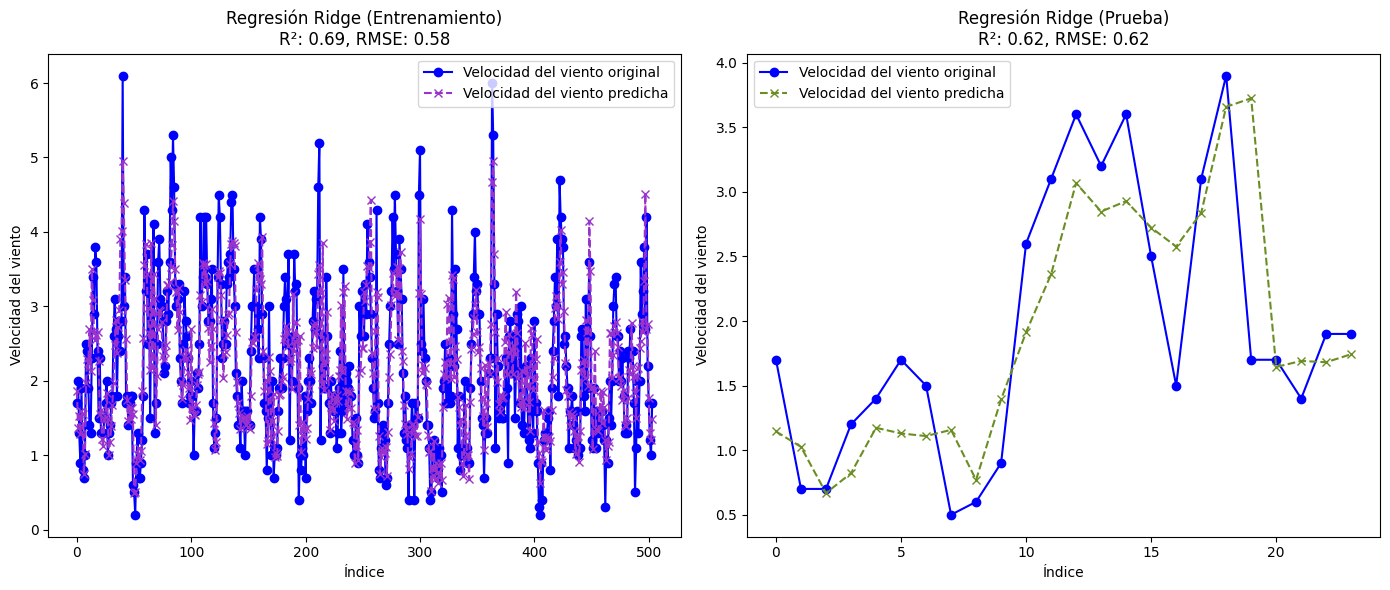

In [122]:
metricas = []
dias = 21
hora = 24
iniciotrain = 0
while (iniciotrain + (dias * 24) + 1) < len(X):  # Mientras que el tamaño del pliegue más la hora sea menor que la longitud de los datos
    fintrain = iniciotrain + (dias * 24)   
    X_train, y_train, X_test, y_test = pliegues(iniciotrain, fintrain, hora)   
    modeloridge.fit(X_train, y_train)
    
    # Entrenamiento
    y_predicciontrain = modeloridge.predict(X_train)
    rmsetrain = mean_squared_error(y_train, y_predicciontrain, squared=False)
    mapetrain = mean_absolute_percentage_error(y_train, y_predicciontrain)
    r2train = r2_score(y_train, y_predicciontrain)
    
    # Test
    y_prediccion = modeloridge.predict(X_test)       
    rmse = mean_squared_error(y_test, y_prediccion, squared=False)
    mape = mean_absolute_percentage_error(y_test, y_prediccion)
    r2 = r2_score(y_test, y_prediccion)
    
    ljungbox, jarquebera = residuos(y_test, y_prediccion)   
    metricas.append({
        'Modelo': 'Regresión Ridge',
        'Dias': dias,
        'Hora': hora,
        'MAPE': mape,
        'RMSE': rmse,
        'R^2': r2,
        'Ljung-Box p-value': ljungbox,
        'Jarque-Bera p-value': jarquebera
    })   
    iniciotrain = fintrain  # Actualizar el inicio para el siguiente pliegue

# Gráfico con lineplot
plt.figure(figsize=(14, 6))

# Conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.plot(range(len(y_train)), y_train, label="Velocidad del viento original", color='blue', linestyle='-', marker='o')
plt.plot(range(len(y_predicciontrain)), y_predicciontrain, label="Velocidad del viento predicha", color='#9A32CD', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"Regresión Ridge (Entrenamiento)\nR²: {r2train:.2f}, RMSE: {rmsetrain:.2f}")
plt.legend()

# Conjunto de prueba
plt.subplot(1, 2, 2)
plt.plot(range(len(y_test)), y_test, label="Velocidad del viento original", color='blue', linestyle='-', marker='o')
plt.plot(range(len(y_prediccion)), y_prediccion, label="Velocidad del viento predicha", color='#6B8E23', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"Regresión Ridge (Prueba)\nR²: {r2:.2f}, RMSE: {rmse:.2f}")
plt.legend()

# Mostrar gráfico
plt.tight_layout()
plt.show()
